$\textbf{Visibility Equation}$


For this work, we simulate a HERA core antenna array,  with antennas closely packed  located at the PAPER site, Karoo South Africa.  We simulate true sky visibility for point sources seen by a baseline $\mathbf{b}_{\textit{a}\textit{b}}$ at frequency $\nu$:
\begin{equation}
\textit{u}(\mathbf{b}_{\textit{a}\textit{b}},\nu)= \sum_{\textit{q}=1}^{\textit{N}_{\textrm{src}}} \textit{A}_{\textit{a}}^*(\hat{\mathbf{s}}_{\textit{q}},\nu)  \textit{A}_{\textit{b}}(\hat{\mathbf{s}}_{\textit{q}},\nu) \textit{S}_{\textit{q}}(\nu/\nu_0)^{-\alpha_{\textit{q}}} \textit{e}^{-2\pi j\frac{\nu}{\textit{c}}\mathbf{b}_{\textit{a}\textit{b}}\cdot \hat{\mathbf{s}}_{\textit{q}}}
\end{equation}
where  $\textit{A}_{\textit{a}}(\hat{\mathbf{s}}_{\textit{q}},\nu)$ and $\textit{A}_{\textit{b}}(\hat{\mathbf{s}}_{\textit{q}},\nu)$ are primary beam of antenna $\textit{a}$ and $\textit{b}$ measured at a point source location $\hat{\mathbf{s}}_{\textit{q}}$  with flux density $\textit{S}_{\textit{q}}$. Here $\nu_0$ and $\alpha_{\textit{q}}$ are the central frequency and spectral index of each point source. $^*$ complex conjugate and $j=\sqrt{-1}$

And observed visibility:
\begin{equation}
   \textit{v}(\mathbf{b}_{\textit{a}\textit{b}},\nu) = \textit{g}_{\textit{a}}(\nu)^{*}\textit{g}_{\textit{b}} \textit{u}(\mathbf{b}_{\textit{a}\textit{b}},\nu) + \textit{n}_{\textit{a}\textit{b}}(\nu)
\end{equation}
where $\textit{g}_{\textit{a}}$ and $\textit{g}_{\textit{b}}$ are the  directional indpendent eantenna gains. Here $\textit{n}_{\textit{a}\textit{b}}$ is the complex visibility noise, and is given by 

\begin{equation}
  \textit{n}_{\textit{a}\textit{b}}(\nu,\textit{t})=  < \sigma_{\textit{a}}(\nu,\textit{t})\sigma_{\textit{b}}^*(\nu,\textit{t})>
\end{equation}

where $\sigma_{\textit{a}}$ and $\sigma_{\textit{b}}$ are antenna noise defined as 
\begin{equation}\label{eq:radm}
    \sigma(\nu) = \frac{\textit{T}_{\textrm{sys}}(\nu,\textit{t})}{\sqrt{\Delta \nu \Delta \textit{t}}}
\end{equation}
where $\textit{T}_{\textrm{sys}}$ antenna system temperature, and $\Delta \nu$ and $\Delta \textit{t}$ are frequency bandwidth and time integration per observation, respectively. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import utils
from astropy.io import fits
import healpy as hp
import pandas as pd




$\textbf{GLEAM Calague 139-200 MHz}$

In [2]:
#loadinng GLEAM Calague 139-200 MHz
#GLEAM_catague = np.loadtxt('GLEAM_Catalogue_139_200MHz_copy.txt')


$\textbf{Radio Point Source Simulation}$

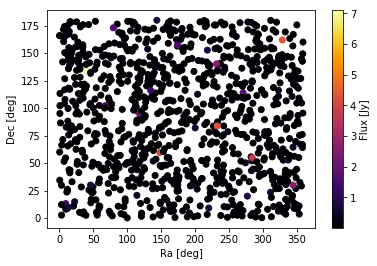

In [81]:


#Radio Point Sources 

nsource = 1000
ras = np.random.uniform(0.0,2.0*np.pi,nsource)
decs = np.random.uniform(0.0,np.pi,nsource)

# point source fluxes distribution from GLEAM Catalog at S_200MHz
S_max = 15.0 #Jy
S_min = 0.001 #Jy
alpha = -1.5

fluxes = ((S_max**(alpha + 1.0) - S_min**(alpha + 1.0))*np.random.uniform(size=nsource) + S_min**(alpha + 1))**(1.0/(alpha + 1))
spec_indices = np.random.randn(nsource)*np.random.normal(1.5,0.01)

freq= np.arange(100.0,200.0,0.1) #HERA frequency resolution of 97kHz
freq_mid = 150 #MHz
flux_freq =[fluxes[i]*np.power(freq[3]/freq_mid,spec_indices[i]) for i in range(len(spec_indices))]

diffuse_signal = np.absolute(np.random.normal(0.0,0.0027,nsource))


plt.scatter(np.rad2deg(ras),np.rad2deg(decs), c=flux_freq, cmap='inferno')
plt.xlabel('Ra [deg]')
plt.ylabel('Dec [deg]')
plt.colorbar(label ='Flux [Jy]')

$\textbf{Antenna Layout in ENU System}$

number of Antennas 61


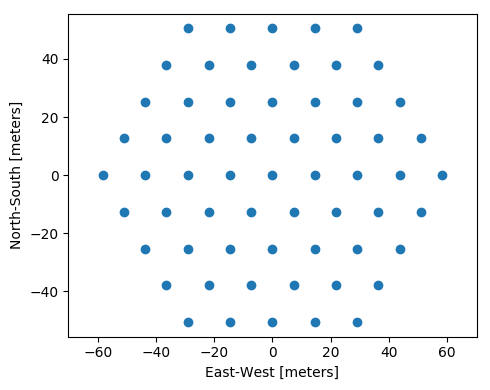

In [15]:
import antpos

antposs = antpos.hex_array(5,split_core= False, outriggers=0)

hera_hex_pos = np.array([list(pos) for pos in antposs.values()])

print 'number of Antennas', len(hera_hex_pos[:,0])

plt.figure(figsize=(5,4), dpi=100)
plt.scatter(hera_hex_pos[:,0],hera_hex_pos[:,1])
plt.xlabel("East-West [meters]")
plt.ylabel("North-South [meters]")
plt.axis('equal')
plt.tight_layout()

In [17]:
hera_hex_pos[0]

array([-29.2       ,  50.57588358,   0.        ])

$\textbf{Transform from ENU to XYZ}$


For a detailed discussion refer to lecture https://web.njit.edu/~gary/728/Lecture6.html


 \begin{gather}
 \begin{bmatrix} X  \\ Y \\ Z \end{bmatrix}
 =
  \begin{bmatrix}
   0 & -\sin(lat) &\cos(lat) \\
  1 & 0 & 0 \\
  0 & \cos(lat) & \sin(lat)
  \end{bmatrix} 
  \begin{bmatrix} E  \\ N \\ U \end{bmatrix}
\end{gather}


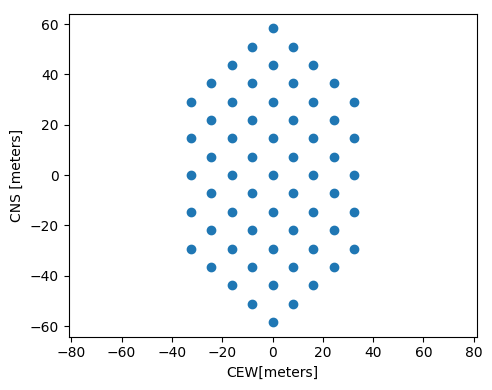

In [20]:
#E-N-U to XYZ Coordinates
#https://web.njit.edu/~gary/728/Lecture6.html

def XYZ_trans_mat(ENU_vec,lat):
    " This matrix transform antenna position from ENU to XYZ given the latitude"
    
    trans_mat = np.matrix([[0.0,-np.sin(lat),np.cos(lat)],[1.0,0.0,0.0],[0.0,np.cos(lat),np.sin(lat)]])
    XYZ =trans_mat.dot(ENU_vec)
    return np.array(XYZ)


#SKA Karoor latitude
lat = -30.721

XYZ_array = np.array([XYZ_trans_mat(hera_hex_pos[i],lat)[0] for i in range(len(hera_hex_pos))])

plt.figure(figsize=(5,4), dpi=100)
plt.scatter(XYZ_array[:,0],XYZ_array[:,1])
plt.xlabel("CEW[meters]")
plt.ylabel("CNS [meters]")
plt.axis('equal')
plt.tight_layout()





$\textbf{Computing Baseline Vectors}$


With 61 antennas there are 108 unique baselines.
1830 baselines


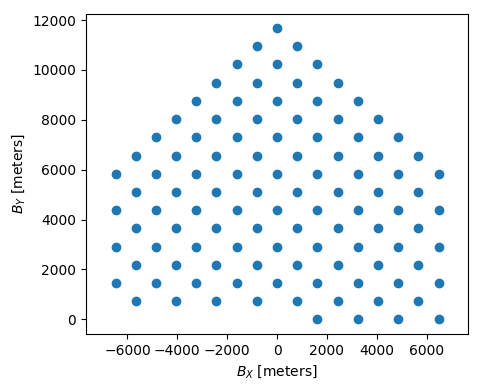

In [35]:
import get_ants_response

ants_indices = np.arange(len(XYZ_array))

ublDict = get_ants_response.InterferometricArray(XYZ_array,ants_indices).CalculateUBLs()[4] #computing Unique Baselines
print 61*60/2 ,"baselines"

B_xyz = np.array(ublDict.keys())

plt.figure(figsize=(5,4), dpi=100)
plt.scatter(B_xyz[:,0],B_xyz[:,1])
plt.xlabel(r"$B_X$ [meters]")
plt.ylabel(r"$B_Y$ [meters]")
plt.axis('equal')
plt.tight_layout()



$\textbf{Transform from $\textit{B}_{\textrm{XYZ}}$ to $\textit{uvw}$ }$


For a detailed discussion refer to lecture https://web.njit.edu/~gary/728/Lecture6.html

Below is direction cosine matrix transformation of $\textit{B}_{\textrm{XYZ}}$ to the direction peperndicular to the phase center ($\textit{h}_0,\delta_0$), thus forming $\textit{uvw}$ 


 \begin{gather} 
 \begin{bmatrix} \textit{u}  \\ \textit{v}\\ \textit{w} \end{bmatrix}
 =\frac{1}{\lambda}
  \begin{bmatrix}
   \sin\textit{h}_0 & \cos\textit{h}_0 & 0 \\
  -\sin\delta_0\cos\textit{h}_0 & sin\delta_0\sin\textit{h}_0 & \cos\delta_0 \\
  \cos\delta_0\cos\textit{h}_0 &-\cos\delta_0\sin\textit{h}_0 & \sin\delta_0
  \end{bmatrix} 
  \begin{bmatrix} \textit{B}_{\textit{X}}  \\ \textit{B}_{\textit{Y}} \\ \textit{B}_{\textit{Z}}\end{bmatrix}
\end{gather}


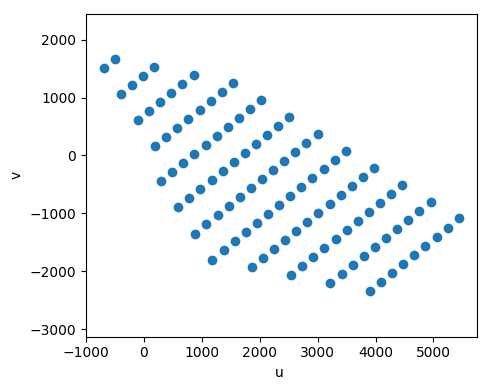

In [44]:
#Transform baseline to projected baseline

#phase center right above SKA karoor

#converting Long/Lat to RA/DEC https://lambda.gsfc.nasa.gov/toolbox/tb_coordconv.cfm

RA_0, Dec_0 = 21.41100,-30.72100 #degrees

def baseline_proj(bl_XYZ,RA_0,Dec_0):
    "Transform baseline to projected baseline given the phase center location in RA, DEC in degrees"
    trans_matt = np.matrix([[np.sin(np.deg2rad(RA_0)),np.cos(np.deg2rad(RA_0)),0.0],[-np.sin(np.deg2rad(Dec_0))*np.cos(np.deg2rad(RA_0)),np.sin(np.deg2rad(Dec_0))*np.sin(np.deg2rad(RA_0)),np.cos(np.deg2rad(Dec_0))],[np.cos(np.deg2rad(Dec_0))*np.cos(np.deg2rad(RA_0)),-np.cos(np.deg2rad(Dec_0))*np.sin(np.deg2rad(RA_0)),np.sin(np.deg2rad(Dec_0))]])
    bl_proj = trans_matt.dot(bl_XYZ)
    
    return np.array(bl_proj)


freq_mid =150e6 # Hz
wavelen = 3.0*10**8/freq_mid 
uvw = np.array([baseline_proj(B_xyz[i],RA_0,Dec_0)[0]*1.0/wavelen for i in range(len(B_xyz))])



plt.figure(figsize=(5,4), dpi=100)
plt.scatter(uvw[:,0],uvw[:,1])
plt.xlabel(r"u ")
plt.ylabel(r"v")
plt.axis('equal')
plt.tight_layout()



$\textbf{Section. 1.1 : Gaussian Primary Beam Model}$

The simplest primary beam model is Gaussain beam, it a good approximation of main lobe. It is a good enough to capture antenna-to-antenna variation due to pointing errors and spectral variation of ful l-width-half-maximum. A two dimensional Gaussian beam centered at origin (assuming the origin coincide with phase center) and   measure at angular co-ordinate $(\theta,\phi)$
\begin{equation}
        \textit{A}(\theta,\phi,\lambda)= \frac{1}{\sqrt{2\pi(\sigma + \varepsilon_{\sigma})^2}}\textit{e}^{-\frac{(\theta + \varepsilon_{\theta})^2 + (\phi+ \varepsilon_{\phi})^2}{2(\sigma +\varepsilon_{\sigma})^2}}
\end{equation}

where $\varepsilon_{\theta}$ and $\varepsilon_{\phi}$ are pointing errors, and $\varepsilon_{\sigma}$ is spectral variation of ful l-width-half-maximum  $\sigma$, is  approximated by Rayleigh diffraction limit
\begin{equation}
        \sigma \approx 1.22\frac{\lambda}{\textit{D}}
\end{equation}

. Here $\textit{D}$ dish diameter.

reference

https://courses.lumenlearning.com/austincc-physics2/chapter/27-6-limits-of-resolution-the-rayleigh-criterion/


Text(0,0.5,'Normalized Power [Unitless]')

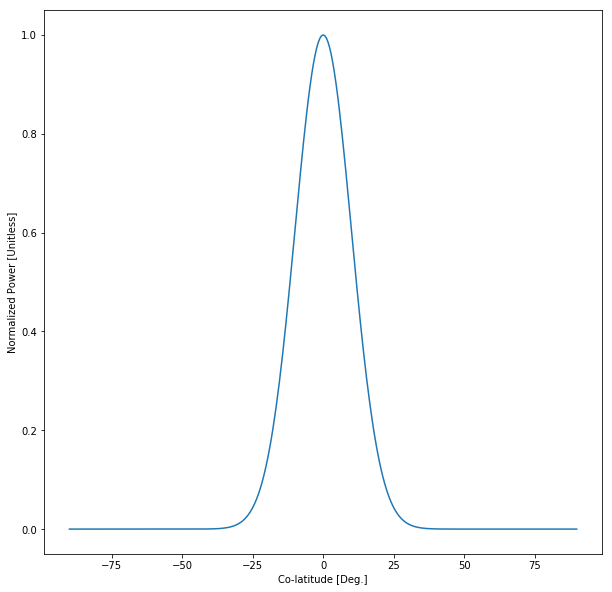

In [48]:
#1d Gaussain with and without beam size and point errors
import beam_simulator

freq_mid = 150e6
sigma_fwhm = beam_simulator.sigma_func(14.0,freq_mid)

theta, phi = np.arange(-np.pi/2.0,np.pi/2.0,0.01),np.arange(-np.pi,np.pi,0.1)

e_theta,e_phi = np.random.normal(0.0,np.deg2rad(0.2)), np.random.normal(0.0,np.deg2rad(0.2))  
sigma_err = np.random.normal(0.0,np.deg2rad(0.2)) # 0.1 degree

gaussian = [beam_simulator.gaussian_beam(theta[i],0.0,sigma_fwhm,0.0,0.0,0.0) for i in range(len(theta))]
gaussian_beam_pt_errors = [beam_simulator.gaussian_beam(theta[theta_j],0.0,sigma_fwhm,e_theta,0.0,0.0) for theta_j in range(len(theta))]
gaussian_beam_sigma_errors = [beam_simulator.gaussian_beam(theta[theta_j],0.0,sigma_fwhm,0.0,0.0,sigma_err) for theta_j in range(len(theta))]
gaussian_beam_pt_sigma_errors = [beam_simulator.gaussian_beam(theta[theta_j],0.0,sigma_fwhm,e_theta,0.0,sigma_err) for theta_j in range(len(theta))]


plt.figure(figsize=(10,10))
plt.plot(np.rad2deg(theta),gaussian,label='Without Errors')
#plt.plot(theta,gaussian_beam_pt_errors,label='Pointing Errors')
#plt.plot(theta,gaussian_beam_sigma_errors,label='Beam Size Errors')
#plt.plot(theta,gaussian_beam_sigma_errors,label='Beam Size & Pointing Errors')
plt.xlabel('Co-latitude [Deg.]')
plt.ylabel('Normalized Power [Unitless]')


$\textbf{Non-redundancy Visibility Simulation}$



In [82]:
#position Error


uvw_test = uvw[0]*wavelen
baseline_error_1perc =np.array([0.004,0.004,0.004])

baseline_error_10perc =np.array([0.01,0.01,0.01])

baseline_error_100perc =np.array([0.1,0.1,0.1])


sky_pos_r = [[np.cos(lalt_i)*np.cos(long_i), np.cos(lalt_i)*np.sin(long_i), np.sin(lalt_i)] for (lalt_i,long_i) in zip(decs,ras)]

vis =np.zeros(len(freq),dtype='complex')
vis_1pc =np.zeros(len(freq),dtype='complex')
vis_10pc =np.zeros(len(freq),dtype='complex')
vis_100pc =np.zeros(len(freq),dtype='complex')

for freq_i in range(freq.size):
    lambda_ = (3e8)/(freq[freq_i]*10**6)
    
    sigma_fwhm = beam_simulator.sigma_func(14.0,freq[freq_i]*10**6)
    
    #phase_1pc = np.array([np.cos(2.0*np.pi*np.dot(uvw_test + baseline_error_1perc,sky_pos_r[r_i])/lambda_) + 1j*np.sin(2.0*np.pi*np.dot(uvw_test + baseline_error_1perc,sky_pos_r[r_i])/lambda_) for r_i in range(len(sky_pos_r))])
    
    #phase_10pc = np.array([np.cos(2.0*np.pi*np.dot(uvw_test + baseline_error_10perc,sky_pos_r[r_i])/lambda_) + 1j*np.sin(2.0*np.pi*np.dot(uvw_test + baseline_error_10perc,sky_pos_r[r_i])/lambda_) for r_i in range(len(sky_pos_r))])
    
    #phase_100pc = np.array([np.cos(2.0*np.pi*np.dot(uvw_test + baseline_error_100perc,sky_pos_r[r_i])/lambda_) + 1j*np.sin(2.0*np.pi*np.dot(uvw_test + baseline_error_100perc,sky_pos_r[r_i])/lambda_) for r_i in range(len(sky_pos_r))])
    
    phase= np.array([np.exp(1j*2.0*np.pi*np.dot(uvw_test,sky_pos_r[r_i]/np.linalg.norm(sky_pos_r[r_i]))/lambda_) for r_i in range(len(sky_pos_r))])
    
    perv_sky = np.array([fluxes[i]*np.power(freq[freq_i]/freq_mid,- spec_indices[i])*np.conj(beam_simulator.gaussian_beam(decs[i],ras[i],sigma_fwhm,0.0,0.0,0.0))*beam_simulator.gaussian_beam(decs[i],ras[i],sigma_fwhm,0.0,0.0,0.0) for i in range(decs.size)])
    vis[freq_i] = np.sum(perv_sky*phase)
    #vis_1pc[freq_i] = np.sum(perv_sky*phase_1pc)
    #vis_10pc[freq_i] = np.sum(perv_sky*phase_10pc)
    #vis_100pc[freq_i] = np.sum(perv_sky*phase_100pc)
    
    
    

In [80]:
freq

array([100. , 100.1, 100.2, 100.3, 100.4, 100.5, 100.6, 100.7, 100.8,
       100.9, 101. , 101.1, 101.2, 101.3, 101.4, 101.5, 101.6, 101.7,
       101.8, 101.9, 102. , 102.1, 102.2, 102.3, 102.4, 102.5, 102.6,
       102.7, 102.8, 102.9, 103. , 103.1, 103.2, 103.3, 103.4, 103.5,
       103.6, 103.7, 103.8, 103.9, 104. , 104.1, 104.2, 104.3, 104.4,
       104.5, 104.6, 104.7, 104.8, 104.9, 105. , 105.1, 105.2, 105.3,
       105.4, 105.5, 105.6, 105.7, 105.8, 105.9, 106. , 106.1, 106.2,
       106.3, 106.4, 106.5, 106.6, 106.7, 106.8, 106.9, 107. , 107.1,
       107.2, 107.3, 107.4, 107.5, 107.6, 107.7, 107.8, 107.9, 108. ,
       108.1, 108.2, 108.3, 108.4, 108.5, 108.6, 108.7, 108.8, 108.9,
       109. , 109.1, 109.2, 109.3, 109.4, 109.5, 109.6, 109.7, 109.8,
       109.9, 110. , 110.1, 110.2, 110.3, 110.4, 110.5, 110.6, 110.7,
       110.8, 110.9, 111. , 111.1, 111.2, 111.3, 111.4, 111.5, 111.6,
       111.7, 111.8, 111.9, 112. , 112.1, 112.2, 112.3, 112.4, 112.5,
       112.6, 112.7,

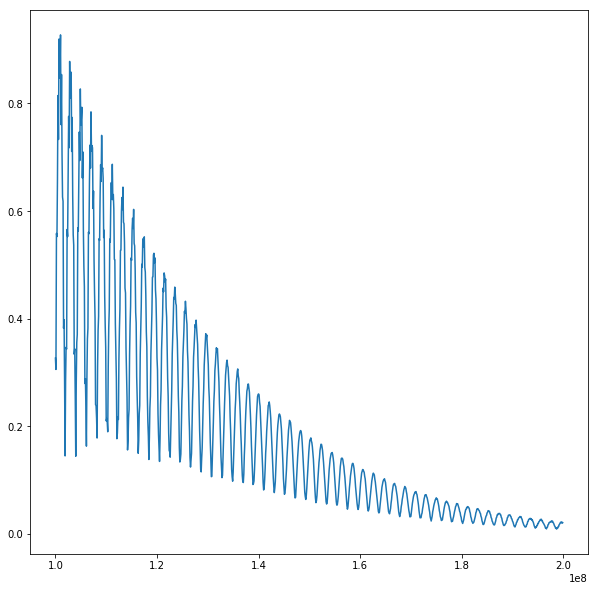

In [83]:
plt.figure(figsize=(10,10))
plt.plot(freq*10**6,np.abs(vis))


5

In [41]:
#Water fall visibility


def vis_per_bl(bl_ind,antspos,ras,dec,src_flux,spec_ind,lst,freq,dy_i,dx_i,dy_j,dx_j,freq_mid =150.0):
    "This function compute visibility for NTIMES and NFREQS"
    
    vis = np.zeros((lst.size,freq.size),dtype='complex')
    
    for lst_i in range(lst.size):
        
        ha = [HA(lst_i,ras[i]) for i in range(ras.size)]
        sky_pos_r = [[np.cos(lalt_i)*np.cos(long_i), np.cos(lalt_i)*np.sin(long_i), np.sin(lalt_i)] for (lalt_i,long_i) in zip(decs,ha)]
        vis_lst_i = []
        for freq_i in range(freq.size):
            lambda_ = (3e8)/(freq[freq_i]*10**6)
            bl_ij = antspos[bl_ind[0]] - antspos[bl_ind[1]]
            phase = np.array([np.cos(2.0*np.pi*np.dot(bl_ij,sky_pos_r[r_i])/lambda_) + 1j*np.sin(2.0*np.pi*np.dot(bl_ij,sky_pos_r[r_i])/lambda_) for r_i in range(len(sky_pos_r))])
            perv_sky = np.array([fluxes[i]*np.power(freq[freq_i]/freq_mid,-spec_ind[i])*np.conj(get_ants_response.get_beam_single_pt(decs[i],ha[i],D_hera,h_feed,freq[freq_i],dy_i,dx_i)[1])*get_ants_response.get_beam_single_pt(decs[i],ha[i],D_hera,h_feed,freq[freq_i],dy_j,dx_j)[1] for i in range(decs.size)])
            vis_tmp = np.sum(perv_sky*phase)
            vis_lst_i.append(vis_tmp)
            
        vis[lst_i,:] = vis_lst_i
        
        
    return vis


HA = lambda lst,ra_obj: lst - ra_obj


hera_hex =  hera_hex_pos #np.load('hera_hex_positions.npy')
ants_indices = np.arange(len(hera_hex))
ublDict = get_ants_response.InterferometricArray(hera_hex,ants_indices).CalculateUBLs()[4]

ras,decs,fluxes,spec_ind = np.load('src_cat.npy')[0], np.load('src_cat.npy')[1], np.load('src_cat.npy')[2], np.load('src_cat.npy')[3]
dh = np.load('feed_positional_displacement_error.npy')

lsts = np.arange(0.0,2,1.63)
freq = np.arange(1)


vis_tmp = vis_per_bl(bl_ind[0],hera_hex,ras,decs,fluxes,spec_ind,lsts,freq,dh[bl_ind[0][0]][0],dh[bl_ind[0][0]][1],dh[bl_ind[0][1]][0],dh[bl_ind[0][1]][1])






With 127 antennas there are 234 unique baselines.


In [ ]:
nsample =100
lambda_ = 2.0

freq_mid = 150.0
spec_ind = spec_indices
bl_ij = [14.6,0.0,0.0]
sky_pos_r = [[np.cos(lalt_i)*np.cos(long_i), np.cos(lalt_i)*np.sin(long_i), np.sin(lalt_i)] for (lalt_i,long_i) in zip(decs,ras)]
phase = np.array([np.cos(2.0*np.pi*np.dot(bl_ij,sky_pos_r[r_i])/lambda_) + 1j*np.sin(2.0*np.pi*np.dot(bl_ij,sky_pos_r[r_i])/lambda_) for r_i in range(len(sky_pos_r))])
vis_diff =[]
vis_t =[]
for i in range(nsample):
    print i
    dy_j,dx_j = np.random.normal(0.0,0.25),np.random.normal(0.0,0.25)
    dy_i,dx_i = np.random.normal(0.0,0.1),np.random.normal(0.0,0.1)
    sky = np.array([fluxes[i]*np.power(150.0/freq_mid,-spec_ind[i])*np.conj(get_ants_response.get_beam_single_pt(decs[i],ras[i],D_hera,h_feed,150,dy_i,dx_i)[1])*get_ants_response.get_beam_single_pt(decs[i],ras[i],D_hera,h_feed,150,dy_j,dx_j)[1] for i in range(decs.size)])
    sky_true = np.array([fluxes[i]*np.power(150.0/freq_mid,-spec_ind[i])*np.conj(get_ants_response.get_beam_single_pt(decs[i],ras[i],D_hera,h_feed,150,0.0,0.0)[1])*get_ants_response.get_beam_single_pt(decs[i],ras[i],D_hera,h_feed,150,0.0,0.0)[1] for i in range(decs.size)])
    vis_true = np.sum(phase*sky_true)
    vis_error = np.sum(phase*sky)
    vis_diff.append(vis_true - vis_error)
    vis_t.append(np.abs(vis_t))
vis_frac_err = (np.abs(np.mean(vis_diff))**2)/np.mean(np.abs(vid_t)**2)  


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15


In [40]:
bl_ind[0][1]

69

In [47]:
bl        
    
    
sky_pos_r = [[np.cos(lalt_i)*np.cos(long_i), np.cos(lalt_i)*np.sin(long_i), np.sin(lalt_i)] for (lalt_i,long_i) in zip(decs,ha)]
vis_lst_i = []
for freq_i in range(freq.size):
            lambda_ = (3e8)/(freq[freq_i]*10**6)
            bl_ij = antspos[bl_ind[0]] - antspos[bl_ind[1]]
            phase = np.array([np.cos(2.0*np.pi*np.dot(bl_ij,sky_pos_r[r_i])/lambda_) + 1j*np.sin(2.0*np.pi*np.dot(bl_ij,sky_pos_r[r_i])/lambda_) for r_i in range(len(sky_pos_r))])
            perv_sky = np.array([fluxes[i]*np.power(freq[freq_i]/freq_mid,-spec_ind[i])*np.conj(get_ants_response.get_beam_single_pt(decs[i],ha[i],D_hera,h_feed,freq[freq_i],dy_i,dx_i))*get_ants_response.get_beam_single_pt(decs[i],ha[i],D_hera,h_feed,freq[freq_i],dy_j,dx_j) for i in range(decs.size)])
            vis_tmp = np.sum(perv_sky*phase)
            vis_lst_i.append(vis_tmp)
            

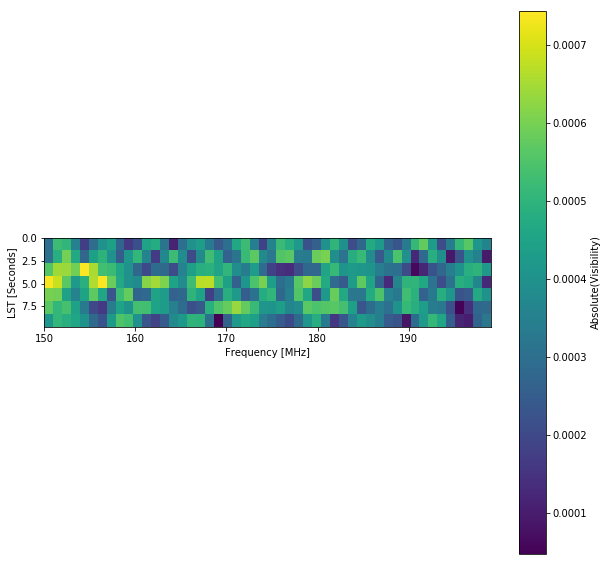

In [32]:
extent =[freq[0],freq[-1],lsts[-1],lsts[0]]

plt.figure(figsize =(10,10))
plt.imshow(np.abs(vis_tmp),extent=extent)
plt.xlabel('Frequency [MHz]')
plt.ylabel('LST [Seconds]')
plt.colorbar(label= r'Absolute(Visibility)')




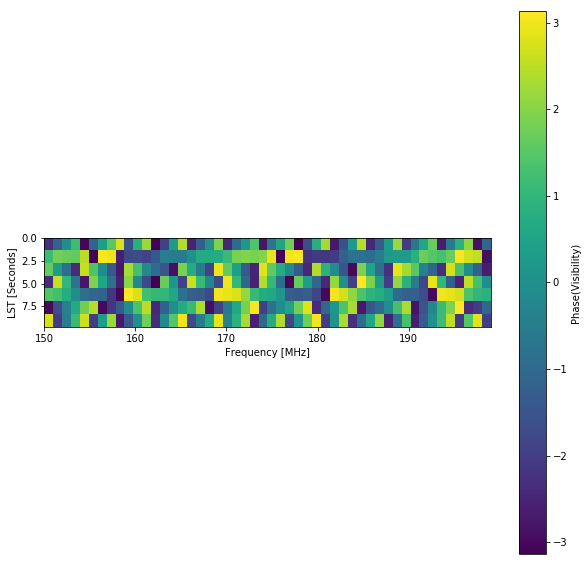

In [33]:
extent =[freq[0],freq[-1],lsts[-1],lsts[0]]

plt.figure(figsize =(10,10))
plt.imshow(np.angle(vis_tmp),extent=extent)
plt.xlabel('Frequency [MHz]')
plt.ylabel('LST [Seconds]')
plt.colorbar(label= r'Phase(Visibility)')




Text(0,0.5,'Amplitude(Visibility)')

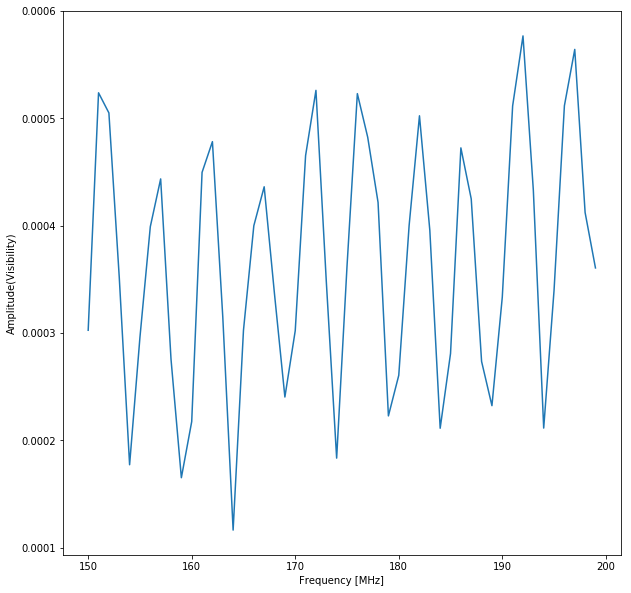

In [40]:
vis_tmp = np.array(vis_tmp)
plt.figure(figsize=(10,10))
plt.plot(freq,np.abs(vis_tmp[0]))
plt.xlabel('Frequency [MHz]')
plt.ylabel('Amplitude(Visibility)')


Text(0,0.5,'Phase(Visibility)')

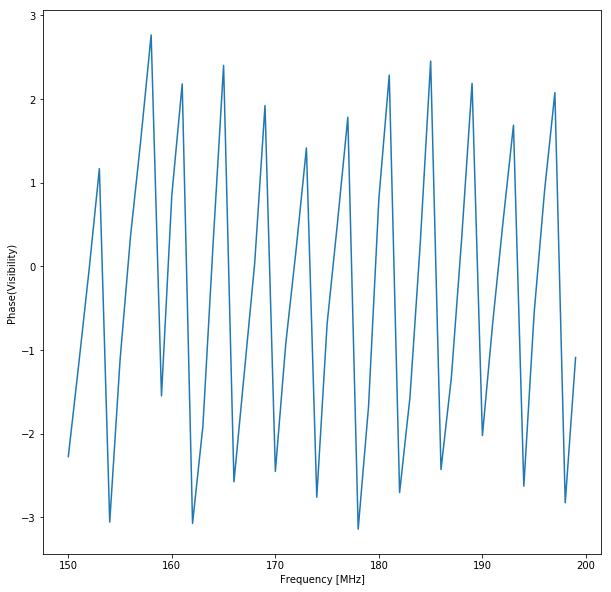

In [41]:
vis_tmp = np.array(vis_tmp)
plt.figure(figsize=(10,10))
plt.plot(freq,np.angle(vis_tmp[0]))
plt.xlabel('Frequency [MHz]')
plt.ylabel('Phase(Visibility)')

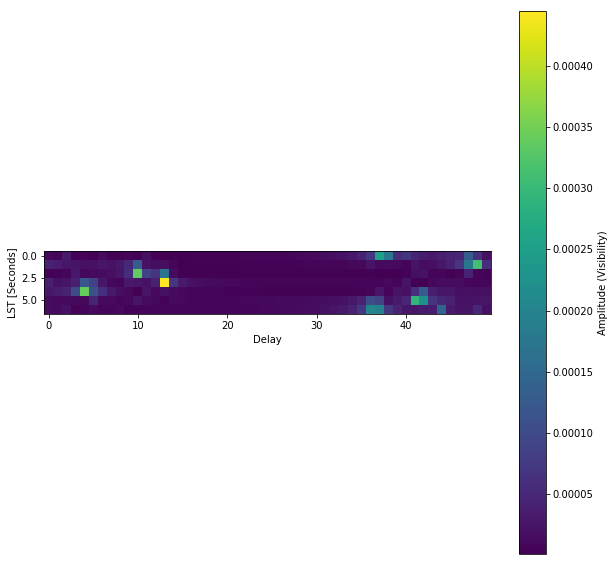

In [43]:
#delay data sim

vis_delay = np.array([np.fft.ifft(vis_tmp[i]) for i in range(vis_tmp.shape[0])])

extent =[freq[0],freq[-1],lsts[-1],lsts[0]]

plt.figure(figsize =(10,10))
plt.imshow(np.abs(vis_delay))
plt.xlabel('Delay')
plt.ylabel('LST [Seconds]')
plt.colorbar(label= r'Amplitude (Visibility)')